# Canny Edge detection 

#### Load all the required libraries

In [204]:
import cv2
from matplotlib import pyplot as plt
import numpy as np
from scipy import ndimage
import imageio.v2 as imageio


#### define util functions

In [205]:
def read_image(img_path='data/78004.jpg'):
    '''
    this function reads img path and returns the image
    Args: 
        img_path (str): path to the image file
    Returns:
        imagio image object    
    '''
    return imageio.imread(img_path).astype('int32')

def show(img):
    '''
    this function is used to display the image
    Args:
        img : image object
    '''
    plt.imshow(img, cmap=plt.get_cmap('gray'))
    plt.show()

def show_beforeafter(I, final_image):
    '''
    disply the before and after images side by side
    Args:
        I: original image
        final_image: image after applying Canny Edge Detection
    '''
    plt.figure()
    f, axarr = plt.subplots(1,2) 

    axarr[0].imshow(I, cmap = plt.get_cmap('gray'))
    axarr[1].imshow(final_image, cmap = plt.get_cmap('gray'))

    plt.show()

def show_sidebyside(img_list, title_list=None):
    '''
    displays all the images in the list side by side
    Args:
        img_list (list): list of images
    '''
    plt.figure()
    f, ax = plt.subplots(1,len(img_list), figsize=(10,7)) 
    for i, img in enumerate(img_list):
        if title_list is not None:
            ax[i].set_title(title_list[i])
        ax[i].imshow(img, cmap = plt.get_cmap('gray'))

    plt.show()        

#### step 1: read a greyscale image from  Berkeley Segmentation Dataset

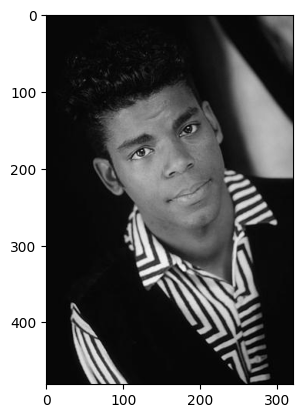

In [206]:
img_path = 'data/302008.jpg'
I = read_image(img_path)
show(I)

#### step 2: create gaussian mask G to convolve with I

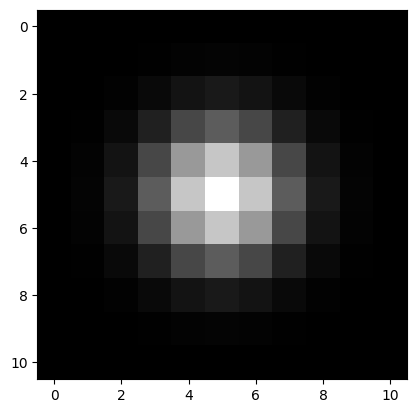

<Figure size 640x480 with 0 Axes>

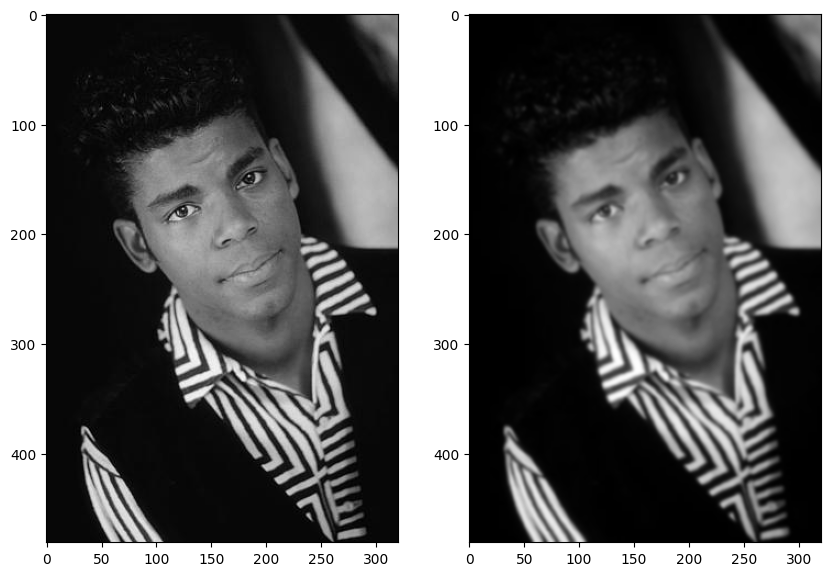

In [207]:
# step 2: create gaussian mask G to convolve with I
def gaussmask(sigma, kernelsize=[3,3]):
    '''
    produces a 1D gaussian mask/kernel of given standard deviation (sigma) and kernel size
    Args:
        sigma (float): standard deviation of the gaussian function
        kernelsize (array/list/tuple): [row, column] size of the kernel 
    Returns:
        Normalised numpy 1D array gaussion function of size (kernelsize) 
    '''
    mid = kernelsize[0] 
    g = np.array([(1/(sigma*np.sqrt(2*np.pi)))*(1/(np.exp((i**2)/(2*sigma**2)))) for i in range(-mid,mid+1)]) # gaussian function
    return g/g.sum() # return the normalised gaussian function

def gaussblur(I, sigma=1.4, kernelsize=[3, 3]):
    G = gaussmask(sigma, [3,3])[np.newaxis] # create a 1D gaussian mask G to convolve with I
    return ndimage.convolve(I, G * G.T)

sigma = 1.4
G = gaussmask(sigma, [5, 5])[np.newaxis] # create a 1D gaussian mask G to convolve with I

show(G * G.T) # show the gaussian filter
show_sidebyside([I, ndimage.convolve(I, G * G.T)]) # show the gaussian filter applied to the Image

#### step 3: Create a one-dimensional mask for the first derivative of the Gaussian in the x and y directions

<Figure size 640x480 with 0 Axes>

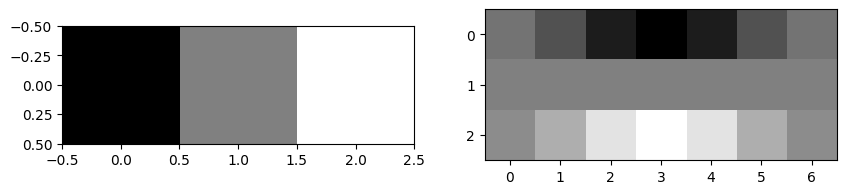

In [208]:
# create a 1D derivative array for both x and y directions
dx = np.array([-0.5, 0, 0.5])[np.newaxis] # transposing 1D array https://stackoverflow.com/questions/5954603/transposing-a-1d-numpy-array
dy = np.transpose(dx)

# get the derivative of the gaussian kernel 
Gx = dx * gaussmask(sigma, np.transpose(dx.shape)) # the size of the kernel is the transpose of the derivative function
Gy = dy * gaussmask(sigma, np.transpose(dy.shape)) # this will create a 2D gaussian derivative mask

show_sidebyside([Gx, Gy])

#### step 4: apply the gaussian derivative mask to the image

<Figure size 640x480 with 0 Axes>

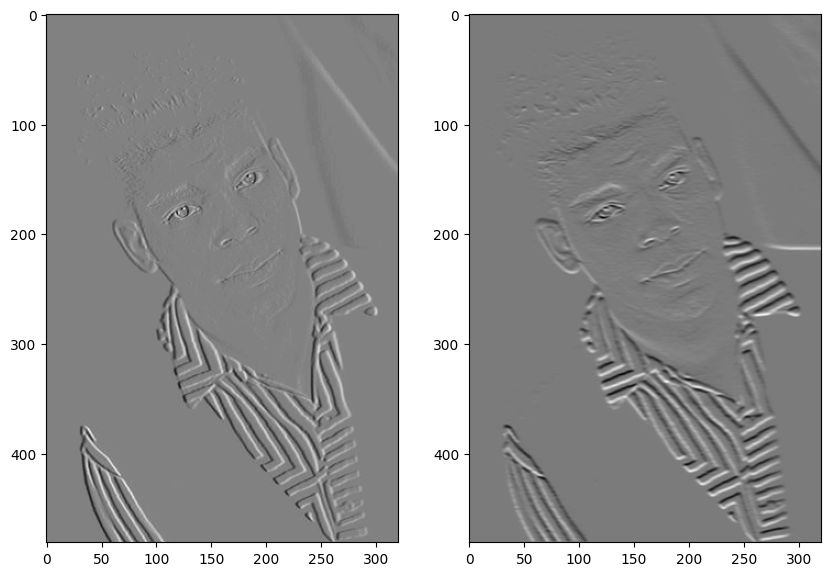

In [209]:
# this step will convolve the mask on the image
Ix = ndimage.convolve(I, Gx)
Iy = ndimage.convolve(I, Gy)

show_sidebyside([Ix, Iy])

#### step 5: Compute the magnitude of the edge response by combining the x and y components.

<Figure size 640x480 with 0 Axes>

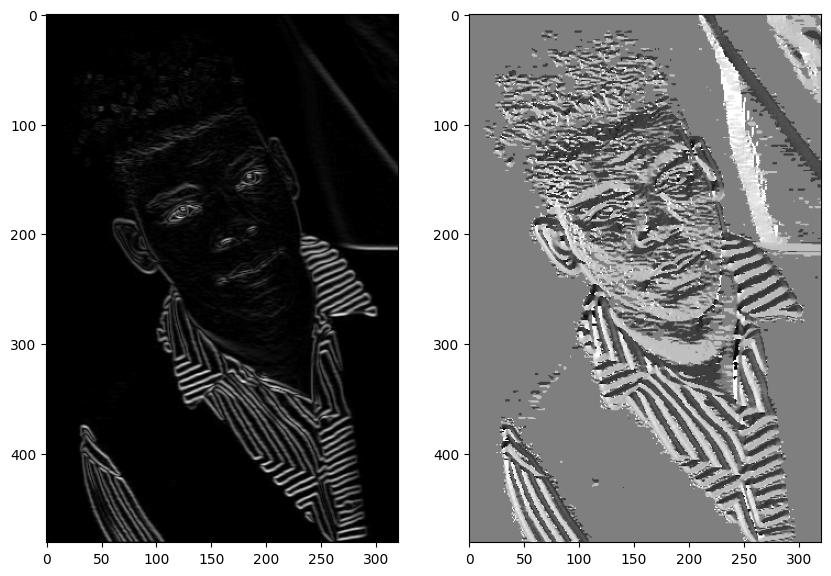

In [210]:
import math
def hypot(Ix, Iy):
    '''
    computes the magnitute of each element of Ix and Iy
    Args:
        Ix (np.array): one of the 2D arrays 
        Iy (np.array): one of the 2D arrays 
    Returns:
        mag (np.array): an array consisting the magnitute each x and y component
    '''
    mag = np.zeros(Ix.shape) # create an empty array to store the magnitute values
    for i in range(Ix.shape[0]): # iterate over all the rows
        for j in range(Ix.shape[1]): # iterate over all the columns
            mag[i][j] = math.sqrt(Ix[i][j]**2 + Iy[i][j]**2) # compute the magnitute of the x and y element at (i,j) 
    return mag

# mag = np.hypot(Ix, Iy) # I could have just used this lol
I_mag = hypot(Ix, Iy) # compute the magnitude at each pixel
I_orient = np.degrees(np.arctan2(Iy, Ix)) # compute the orientation at each pixel

show_sidebyside([I_mag, I_orient])


#### step 6: Non-Max Supression

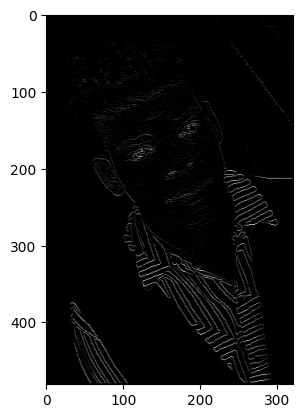

In [211]:
# step 6
def NonMaxSup(I_mag, I_orient):
    '''
    This function computes Non-Max Supression of the magnitudes of the each pixel based on their orientation
    Args:
        I_mag (np.array): an array consisting the magnitute each pixel
        I_orient (np.array): an array consisting the orientation at each pixel
    Return:
        an array consisting the non-max suppressed magnitude values at eaxh pixel
    '''
    NMS = np.zeros(I_mag.shape) # create an empty array to store the non-max suppressed magnitude values later
    for i in range(1, int(I_mag.shape[0]) - 1): # iterate over the rows
        for j in range(1, int(I_mag.shape[1]) - 1): # iterate over the columns
            # if the orientation at the pixel (i,j) is between -22.5 and 22.5 or between -157.5 and 157.5
            if((I_orient[i,j] >= -22.5 and I_orient[i,j] <= 22.5) or (I_orient[i,j] <= -157.5 and I_orient[i,j] >= 157.5)):
                # if the magnitude at the pixel (i,j) is greater than both it's adjacent pixel values at (i, j+1) and (i, j-1)
                if((I_mag[i,j] > I_mag[i,j+1]) and (I_mag[i,j] > I_mag[i,j-1])):
                    # save the magnitude value at pixel (i, j) since it's the max value in that region 
                    NMS[i,j] = I_mag[i,j]
                else: # all the other values are non-max suppressed
                    NMS[i,j] = 0
            # if the orientation at the pixel (i,j) is between 22.5 and 67.5 or between -112.5 and -157.5                    
            if((I_orient[i,j] >= 22.5 and I_orient[i,j] <= 67.5) or (I_orient[i,j] <= -112.5 and I_orient[i,j] >= -157.5)):
                # if the magnitude at the pixel (i,j) is greater than both it's adjacent pixel values at (i+1, j+1) and (i-1, j-1)
                if((I_mag[i,j] > I_mag[i+1,j+1]) and (I_mag[i,j] > I_mag[i-1,j-1])):
                    # save the magnitude value at pixel (i, j) since it's the max value in that region 
                    NMS[i,j] = I_mag[i,j]
                else: # all the other values are non-max suppressed
                    NMS[i,j] = 0
            # if the orientation at the pixel (i,j) is between 67.5 and 112.5 or between -67.5 and -112.5                                        
            if((I_orient[i,j] >= 67.5 and I_orient[i,j] <= 112.5) or (I_orient[i,j] <= -67.5 and I_orient[i,j] >= -112.5)):
                # if the magnitude at the pixel (i,j) is greater than both it's adjacent pixel values at (i+1, j) and (i-1, j)
                if((I_mag[i,j] > I_mag[i+1,j]) and (I_mag[i,j] > I_mag[i-1,j])):
                    # save the magnitude value at pixel (i, j) since it's the max value in that region 
                    NMS[i,j] = I_mag[i,j]
                else:  # all the other values are non-max suppressed
                    NMS[i,j] = 0
            # if the orientation at the pixel (i,j) is between 112.5 and 157.5 or between -22.5 and -67.5 
            if((I_orient[i,j] >= 112.5 and I_orient[i,j] <= 157.5) or (I_orient[i,j] <= -22.5 and I_orient[i,j] >= -67.5)):
                # if the magnitude at the pixel (i,j) is greater than both it's adjacent pixel values at (i+1, j-1) and (i-1, j+1)
                if((I_mag[i,j] > I_mag[i+1,j-1]) and (I_mag[i,j] > I_mag[i-1,j+1])):
                    # save the magnitude value at pixel (i, j) since it's the max value in that region 
                    NMS[i,j] = I_mag[i,j]
                else:  # all the other values are non-max suppressed
                    NMS[i,j] = 0

    return NMS

NMS = NonMaxSup(I_mag, I_orient) # perform Non-Max Supression
show(NMS)

#### step 7: Double threshold Hysterisis

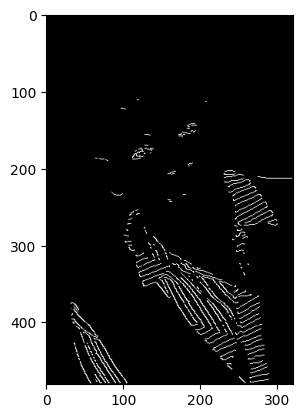

In [212]:
# step 7
# This recursive approach would recurse through every strong edge and find all connected weak edges
def DoThreshHyst(img, HTR=0.32, LTR=0.30):
    '''
    performs Double Threshold Hysterisis by recursing through every strong edge and find all connected weak edges
    if the pixel's intensity is less than the low threshold value it is supressed
    if it's between low and high threshold then we check if any neighbouring pixel has intensity above the high threshold otherwise 
        if yes, we consider the value
        if no, we supress it
    if it's above the high threshold value we consider it
    Args:
        img (np.array): the input image
        HTR (float): High Threshold Ratio, the upper limit threshold value
        LTR (float): Low Threshold Ratio, the lower limit threshold value
    Returns:
        returns the final image after performing Double Threshold Hysterisis
    '''
    GSup = np.copy(img) # create a copy of the image
    h = int(GSup.shape[0]) # get the height of the image
    w = int(GSup.shape[1]) # get the width of the image
    highThreshold = np.max(GSup) * HTR # compute the high threshold value 
    lowThreshold = highThreshold * LTR # compute the low threshold value 

    # experimenting with manually entering the threshold values
    # highThreshold = 21
    # lowThreshold = 15
    
    for i in range(1,h-1): # iterate over the rows
        for j in range(1,w-1): # iterate over the columns
            # if the pixel intensity is greater than the high threshold then we consider the pixel value
            if(GSup[i,j] > highThreshold): 
                GSup[i,j] = 1
            # else if the pixel intensity is lower than the low threshold we supress the pixel value
            elif(GSup[i,j] < lowThreshold):
                GSup[i,j] = 0
            # else we check if the neighbouring pixel values are greater than the high threshold 
            else:
                # consider the pixel value if any of the neighbouring value is greater than the high threshold
                if((GSup[i-1,j-1] > highThreshold) or 
                    (GSup[i-1,j] > highThreshold) or
                    (GSup[i-1,j+1] > highThreshold) or
                    (GSup[i,j-1] > highThreshold) or
                    (GSup[i,j+1] > highThreshold) or
                    (GSup[i+1,j-1] > highThreshold) or
                    (GSup[i+1,j] > highThreshold) or
                    (GSup[i+1,j+1] > highThreshold)):
                    GSup[i,j] = 1
        # x = np.sum(GSup == 1)
    
    # This is done to remove/clean all the weak edges which are not connected to strong edges
    GSup = (GSup == 1) * GSup 
    
    return GSup

final_image = DoThreshHyst(NMS)
show(final_image)    

In [213]:
def canny_edge(I, sigma, HTR, LTR):
    '''
    this function performs Canny Edge Detection (steps 1-7) and returns the final image
    Args: 
        I (np.array): Image object
        sigma (float): the sigma > 0, intensity of gaussian blur
        HTR (float): High Threshold Ratio, the upper limit threshold value
        LTR (float): Low Threshold Ratio, the lower limit threshold value
    return:
        final_image (np.array): final image with Canny Edge Detection
    '''
    # step 2 and 3: create a 1D derivative array for both x and y directions, create a gaussion mask and get the derivative of the gaussian kernel 
    # This creates a Gaussian derivative mask in both x and y directions
    dx = np.array([-0.5, 0, 0.5])[np.newaxis] # transposing 1D array https://stackoverflow.com/questions/5954603/transposing-a-1d-numpy-array
    dy = np.transpose(dx)
    
    Gx = dx * gaussmask(sigma, np.transpose(dx.shape))
    Gy = dy * gaussmask(sigma, np.transpose(dy.shape))

    # step 4: apply the gaussion derivate mask to the Image
    Ix = ndimage.convolve(I, Gx)
    Iy = ndimage.convolve(I, Gy)

    # step 5: Compute the magnitude of the edge response by combining the x and y components.
    I_mag = np.hypot(Ix, Iy)
    I_orient = np.degrees(np.arctan2(Iy, Ix))

    # step 6: apply Non-Max Supression
    NMS = NonMaxSup(I_mag, I_orient)
    
    # step 7: apply Double Threshold Hysterisis
    final_image = DoThreshHyst(NMS, HTR=HTR, LTR=LTR)

    return final_image
    

<Figure size 640x480 with 0 Axes>

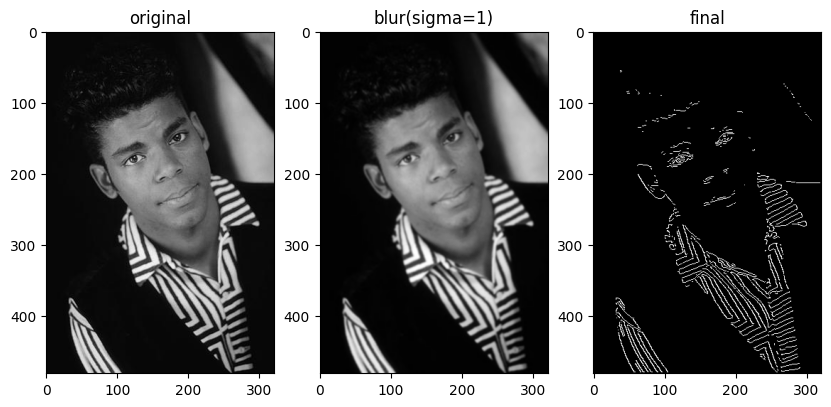

<Figure size 640x480 with 0 Axes>

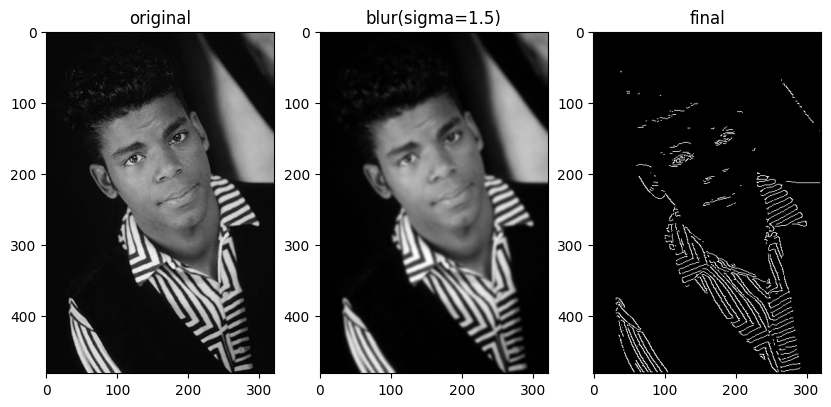

<Figure size 640x480 with 0 Axes>

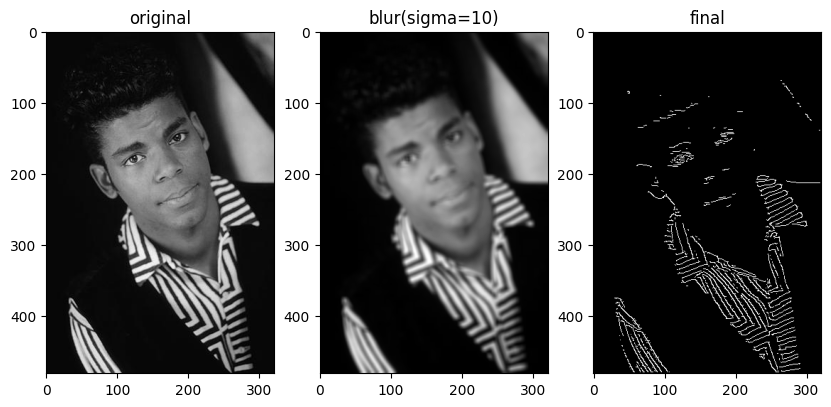

In [214]:
HTR = 0.2
LTR = 0.15
img_path = 'data/302008.jpg'

sigma = 1
I = read_image(img_path=img_path)
I_gauss = gaussblur(I, sigma=sigma)
final_image = canny_edge(I, sigma, HTR, LTR)
show_sidebyside([I, I_gauss, final_image], [f'original', f'blur({sigma=})', 'final'])

sigma = 1.5
I_gauss = gaussblur(I, sigma=sigma)
final_image = canny_edge(I, sigma, HTR, LTR)
show_sidebyside([I, I_gauss, final_image], [f'original', f'blur({sigma=})', 'final'])

sigma = 10
I_gauss = gaussblur(I, sigma=sigma)
final_image = canny_edge(I, sigma, HTR, LTR)
show_sidebyside([I, I_gauss, final_image], [f'original', f'blur({sigma=})', 'final'])

The best sigma value is **sigma=1.5** because it eliminates suitable amount of some noise while retaining almost all important edges unlike **sigma=10**

<Figure size 640x480 with 0 Axes>

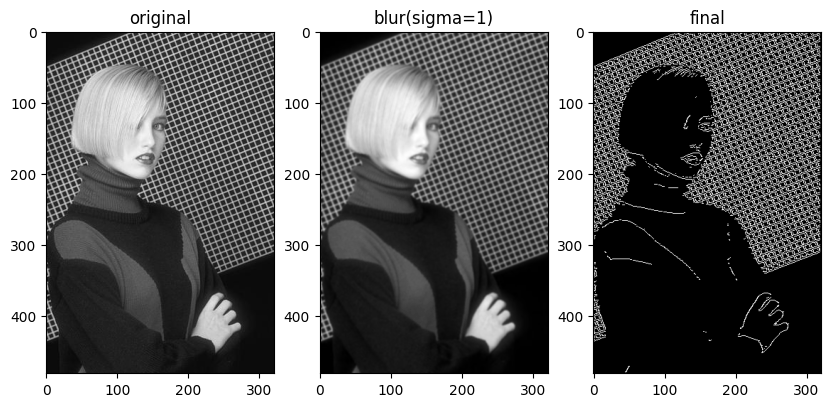

<Figure size 640x480 with 0 Axes>

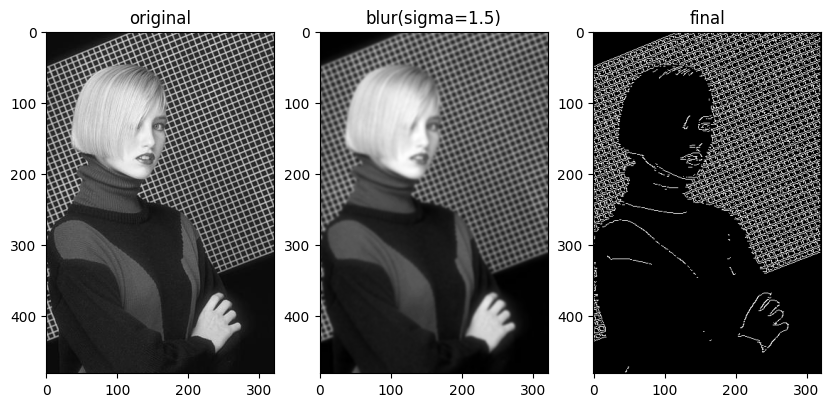

<Figure size 640x480 with 0 Axes>

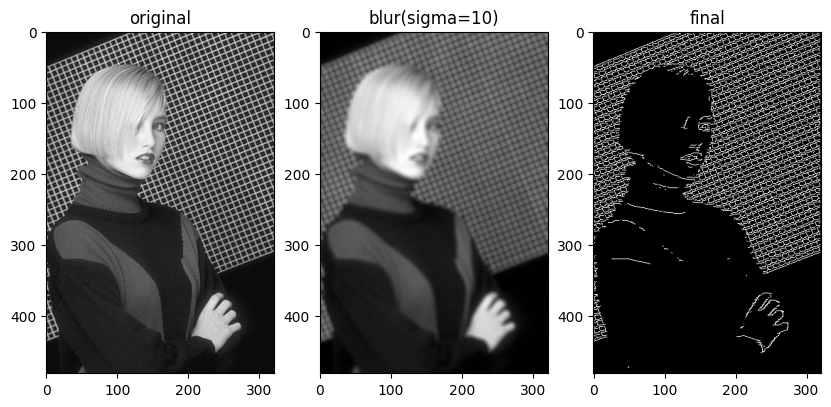

In [215]:
img_path = 'data/198023.jpg'
HTR = 0.15
LTR = 0.1

sigma = 1
I = read_image(img_path=img_path)
I_gauss = gaussblur(I, sigma=sigma)
final_image = canny_edge(I, sigma, HTR, LTR)
show_sidebyside([I, I_gauss, final_image], [f'original', f'blur({sigma=})', 'final'])

sigma = 1.5
I_gauss = gaussblur(I, sigma=sigma)
final_image = canny_edge(I, sigma, HTR, LTR)
show_sidebyside([I, I_gauss, final_image], [f'original', f'blur({sigma=})', 'final'])

sigma = 10
I_gauss = gaussblur(I, sigma=sigma)
final_image = canny_edge(I, sigma, HTR, LTR)
show_sidebyside([I, I_gauss, final_image], [f'original', f'blur({sigma=})', 'final'])

**sigma=1** is the best parameter here, as sigma is increased, the details of the person in the foreground are decreasing as well

<Figure size 640x480 with 0 Axes>

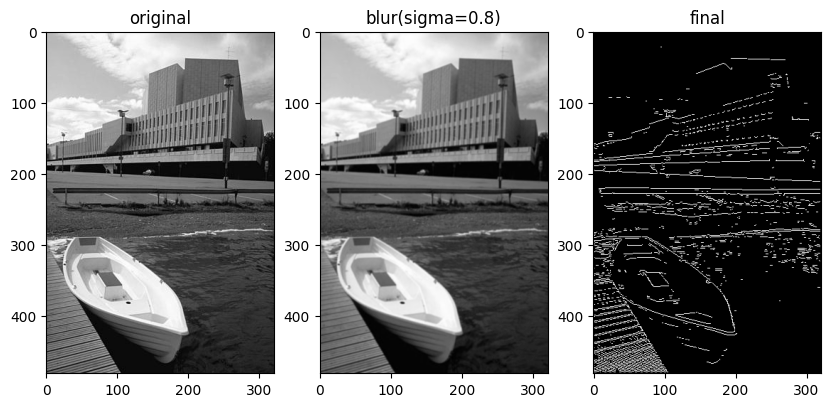

<Figure size 640x480 with 0 Axes>

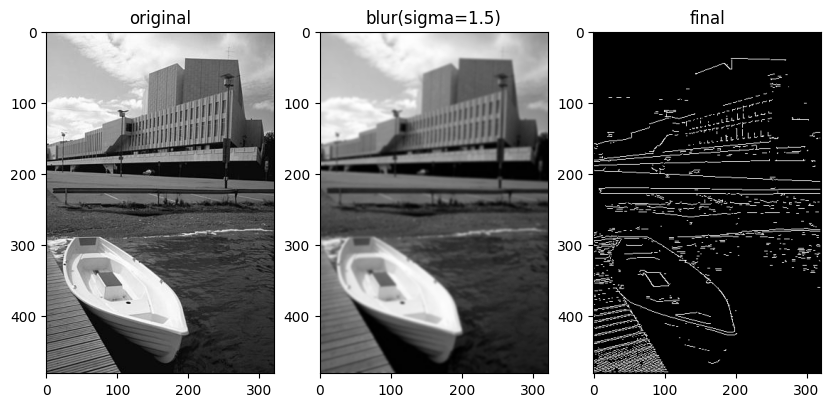

<Figure size 640x480 with 0 Axes>

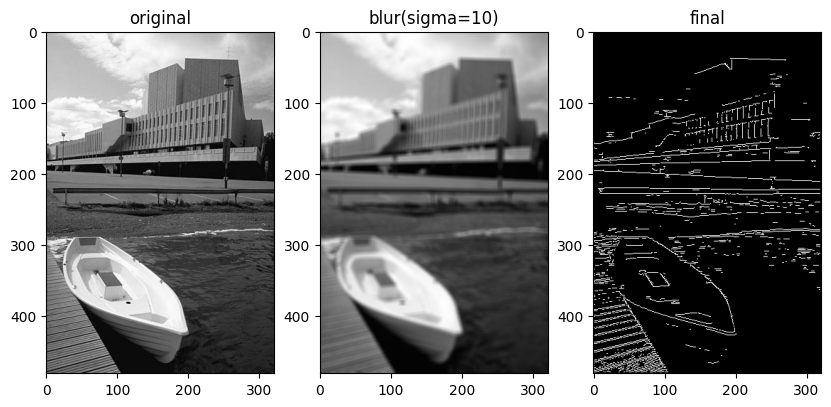

In [216]:
img_path = 'data/78004.jpg'
HTR = 0.17
LTR = 0.12

sigma = 0.8
I = read_image(img_path=img_path)
I_gauss = gaussblur(I, sigma=sigma)
final_image = canny_edge(I, sigma, HTR, LTR)
show_sidebyside([I, I_gauss, final_image], [f'original', f'blur({sigma=})', 'final'])

sigma = 1.5
I_gauss = gaussblur(I, sigma=sigma)
final_image = canny_edge(I, sigma, HTR, LTR)
show_sidebyside([I, I_gauss, final_image], [f'original', f'blur({sigma=})', 'final'])

sigma = 10
I_gauss = gaussblur(I, sigma=sigma)
final_image = canny_edge(I, sigma, HTR, LTR)
show_sidebyside([I, I_gauss, final_image], [f'original', f'blur({sigma=})', 'final'])

Here the best **sigma=1.5** retains the edges of the building int he background while keeping the details of the boat in the foreground intact

<Figure size 640x480 with 0 Axes>

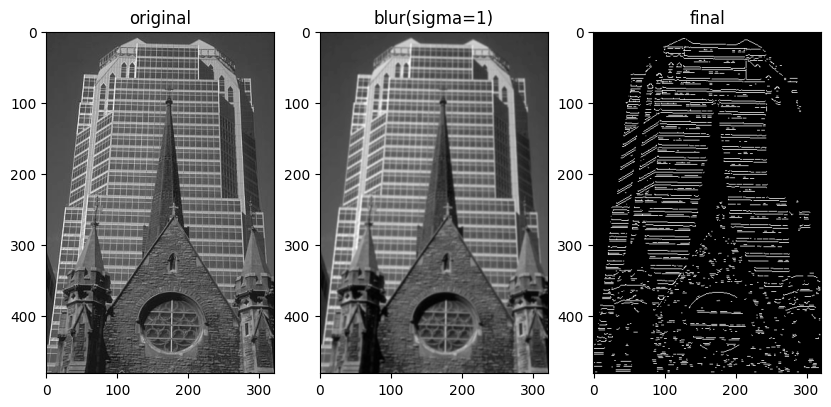

<Figure size 640x480 with 0 Axes>

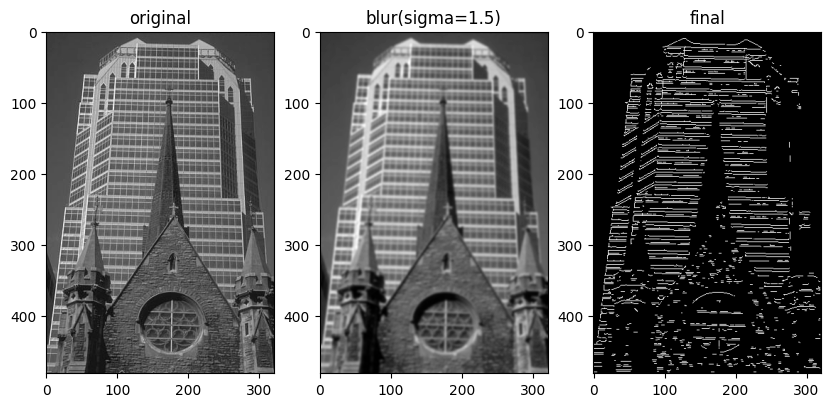

<Figure size 640x480 with 0 Axes>

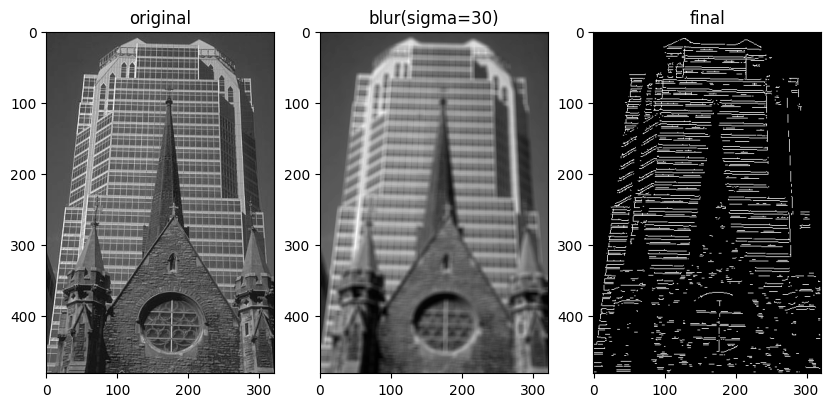

In [217]:
img_path = 'data/277095.jpg'
sigma = 20
HTR = 0.32
LTR = 0.28

sigma = 1
I = read_image(img_path=img_path)
I_gauss = gaussblur(I, sigma=sigma)
final_image = canny_edge(I, sigma, HTR, LTR)
show_sidebyside([I, I_gauss, final_image], [f'original', f'blur({sigma=})', 'final'])

sigma = 1.5
I_gauss = gaussblur(I, sigma=sigma)
final_image = canny_edge(I, sigma, HTR, LTR)
show_sidebyside([I, I_gauss, final_image], [f'original', f'blur({sigma=})', 'final'])

sigma = 30
I_gauss = gaussblur(I, sigma=sigma)
final_image = canny_edge(I, sigma, HTR, LTR)
show_sidebyside([I, I_gauss, final_image], [f'original', f'blur({sigma=})', 'final'])

In this image **sigma=1.5** is the best since it retains sharp edges and most details